## Todo:

1. Make box and whisker of ER per cluster

In [1]:
# %load_ext autoreload
# %autoreload 2

import warnings
warnings.filterwarnings("ignore") # pandas is bugging me

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import sys
import os
from enum import Enum
sys.path.append("src")
import operator
import pandas as pd
from importlib import reload
import preprocessing.data_loading as data_loading
import models.rnn as rnn
import analysis.umap_analysis as umap
import umap.umap_ as do_umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.pyplot import cm
from tensorflow import keras
from sklearn import preprocessing, manifold, decomposition
from sklearn import metrics
from scipy.spatial.distance import cdist

from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import subprocess
import logomaker as lm

In [61]:
class Y_AXIS_UNIT(Enum):
    COUNTS = 1
    BITS = 2


def muscle_align(seqs, seq_record_name, align_name):
    SeqIO.write(
        [SeqRecord(Seq(seq), id=seq) for seq in seqs],
        seq_record_name,
        "fasta",
    )
    subprocess.call(
        "muscle -super5 %s -output %s" % (seq_record_name, align_name),
        shell=True,
    )
    with open(align_name, "r") as f:
        raw_seqs = f.readlines()
    return [seq.strip() for seq in raw_seqs if ("#" not in seq) and (">") not in seq]


def save_web_logo_alignment(
    seqs,
    axis,
    save_to,
    seq_record_name="_example.fasta",
    align_name="_align.fasta",
    web_logo_name="logo.png",
    to_type="counts",
    align=True,
):
    if align:
        seqs = muscle_align(seqs, seq_record_name, align_name)
    counts_mat = lm.alignment_to_matrix(seqs, to_type=to_type)
    counts_mat.head()
    logo = lm.Logo(counts_mat, ax=axis, color_scheme="hydrophobicity")
    plt.savefig(os.path.join(save_to,web_logo_name))


def generate_weblogos_by_library(
    df, target_protein_name, title, save_to, y_axis_units=Y_AXIS_UNIT.BITS, library_count_threshold=1
):
    def peptide_passes(seq):
        cysteine_positions = [idx for idx, i in enumerate(seq) if i == "C"]
        # We only want completely linear sequences (no Cysteines)
        # Or well behaving macrocylcles (only 2 Cysteines)
        return len(cysteine_positions) == 0 or len(cysteine_positions) == 2

    def get_library_name(seq):
        cysteine_positions = [idx for idx, i in enumerate(seq) if i == "C"]
        if len(cysteine_positions) >= 2:
            return (
                "Macrocyclic "
                + str(len(seq))
                + "mers"
                + " w/ C's @ "
                + str(cysteine_positions)
            )
        else:
            # For Peptides with only 1 or 0 Cysteines, we should just treat them as linear
            return "Linear " + str(len(seq)) + "mers"

    df = df[df["Peptide"].apply(lambda seq: peptide_passes(seq))]
    # Create a key that takes into account len & cysteine placements within peptide
    macrocycle_idx_df = pd.DataFrame(
        df["Peptide"].apply(lambda seq: get_library_name(seq))
    )
    library_to_indices = macrocycle_idx_df.groupby("Peptide").indices
    # Collect Dict into a List & Sort by relevance, discard single library matches
    # (aka first element in library_and_seqs_list represents the most common library)
    library_and_seqs_list = sorted(
        [
            (lib, df["Peptide"].iloc[idxs])
            for lib, idxs in library_to_indices.items()
            if len(idxs) > library_count_threshold
        ],
        key=lambda tup: len(tup[1]),
        reverse=True,
    )
    fig, axs = plt.subplots(len(library_and_seqs_list), 1)

    try:
        for idx, (lib_name, seqs) in enumerate(library_and_seqs_list):
            axis = axs[idx]
            axis.set_title(
                lib_name + " (" + str(len(seqs)) + " peptides)",
                size=10,
            )
            axis.set_xticks([])
            if y_axis_units == Y_AXIS_UNIT.BITS:
                save_web_logo_alignment(save_to=save_to,
                    seqs=seqs, align=False, axis=axis, to_type="information"
                )
                axis.set_ylim([0,4])
            elif y_axis_units == Y_AXIS_UNIT.COUNTS:
                save_web_logo_alignment(save_to=save_to,seqs=seqs, align=False, axis=axis, to_type="counts")
    except TypeError:
        axs.set_title(
                lib_name + " (" + str(len(seqs)) + " peptides)",
                size=10,
            )
        axs.set_xticks([])
        if y_axis_units == Y_AXIS_UNIT.BITS:
            save_web_logo_alignment(save_to=save_to,
                seqs=seqs, align=False, axis=axs, to_type="information"
                )
            axs.set_ylim([0,4])
        elif y_axis_units == Y_AXIS_UNIT.COUNTS:
            save_web_logo_alignment(save_to=save_to, seqs=seqs, align=False, axis=axs, to_type="counts")

    fig.suptitle(target_protein_name + " Weblogos by Library", fontsize=15)
    fig.subplots_adjust(hspace=0.5)
    fig.add_subplot(111, frameon=False)
    # hide y & x tick labels of the big axis
    plt.tick_params(
        labelcolor="none",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
    )
    plt.xlabel("Alignment Position")
    if y_axis_units == Y_AXIS_UNIT.BITS:
        plt.ylabel("Information (Bits)")
    elif y_axis_units == Y_AXIS_UNIT.COUNTS:
        plt.ylabel("Residue Positional Counts")
    name = target_protein_name + " Weblogos by Library" + title
    plt.savefig(os.path.join(save_to,name + '.png'),dpi=300)
    plt.show()

In [33]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)

save_to = os.path.join('C:/','Users','Michael Lee','1 Phage Display Data','K means clustering')

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is -0.6565247891915524


In [4]:
R3_filt_MDM2 = R3_lib.query('poi_log_fold > 3 & pvalues < 0.05').drop(['mCDH2 1','mCDH2 2','mCDH2 3'], axis=1)

R3_filt_12ca5 = R3_lib.query('poi_log_fold < -3 & pvalues < 0.05').drop(['mCDH2 1','mCDH2 2','mCDH2 3'], axis=1)

<AxesSubplot:xlabel='poi_log_fold', ylabel='poi_log_pvalue'>

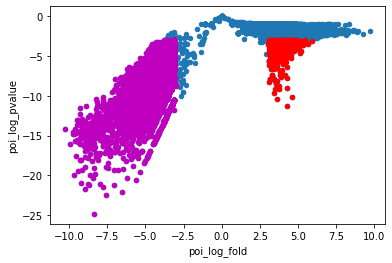

In [5]:
fig, ax = plt.subplots()
R3_lib.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', ax = ax)
R3_filt_MDM2.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', c = 'r', ax = ax)
R3_filt_12ca5.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', c = 'm', ax = ax)

In [6]:
ER_12ca5 = pd.read_csv(os.path.join(os.getcwd(),'data','12ca5_merged_ER.csv'),index_col=False)
ER_MDM2 = pd.read_csv(os.path.join(os.getcwd(),'data','MDM2_merged_ER.csv'),index_col=False)

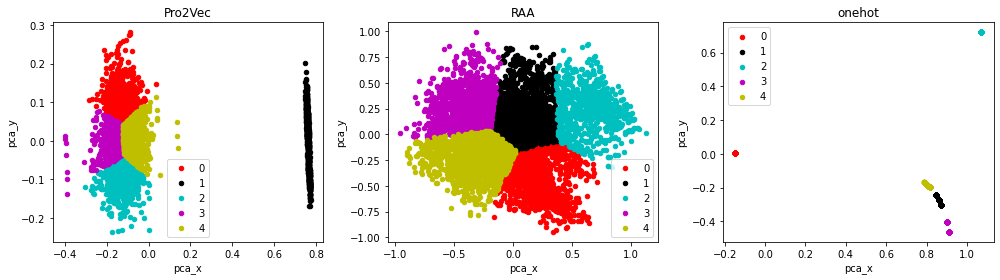

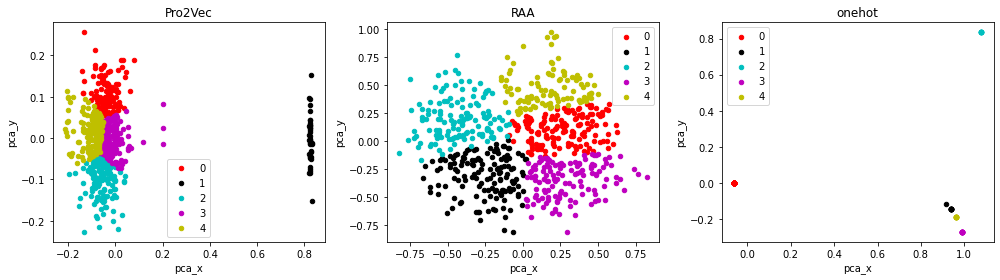

In [7]:
hit_libs = [R3_filt_12ca5,R3_filt_MDM2]
n_clusters = 5
SEED = 69

reps = ['Pro2Vec','RAA','onehot']
prots = ['12ca5','MDM2']
colors = ['r','k','c','m','y']

for j,lib in enumerate(hit_libs):
    fig, axs = plt.subplots(1,3,figsize=(14,4))
    for i,rep in enumerate(reps):
        data_rep = lib[rep].to_list()
        if rep == 'onehot':
            data_rep = [a[0] for a in data_rep] # fix formatting

        reducer_scaled_dict = {}
        embedding_scaled_dict = {}

        pca = decomposition.PCA(n_components=2, random_state=SEED)
        embedding = pca.fit_transform(data_rep)

        pca_fn = pca
        pca_embedding = embedding

        clusterer = Pipeline(
            [
                ('kmeans',
                 KMeans(
                     n_clusters = n_clusters,
                     init = 'k-means++',
                     n_init = 50,
                     max_iter = 500,
                     random_state = 69))])

        pipe = Pipeline(
            [
                ('clusterer',clusterer)
            ])
        # most rigorous pipeline NA    
            
        out = pipe.fit(pca_embedding)

        clusters = out['clusterer'].transform(pca_embedding)
        labels = out['clusterer']['kmeans'].labels_
        groups = np.unique(labels)

        df_pca = pd.DataFrame()
        df_pca['pca_x'] = pca_embedding[:,0]
        df_pca['pca_y'] = pca_embedding[:,1]
        df_pca['label'] = labels
        lib[f'label_{rep}_{prots[j]}'] = labels
        
        for l in np.unique(labels):
            df_sub = df_pca.query('label == @l')
            df_sub.plot.scatter(x = 'pca_x', y = 'pca_y',c=colors[l],ax=axs[i])
        axs[i].set_title(f'{rep}')
        axs[i].legend(['0','1','2','3','4'],loc='best')
    fig.tight_layout()
    fig.show()

<AxesSubplot:xlabel='poi_log_fold', ylabel='poi_log_pvalue'>

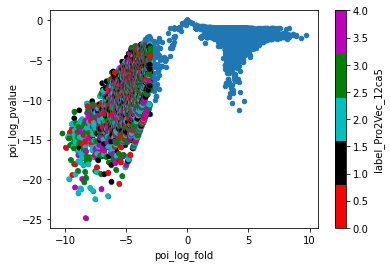

In [8]:
cmap = ListedColormap(['r','k','c','g','m']) # lol
fig, ax = plt.subplots()
R3_lib.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', ax = ax)
hit_libs[0].plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', c = 'label_Pro2Vec_12ca5', colormap=cmap, ax = ax)

In [9]:
# %%time

# umap_fns = {}
# umap_embeddings = {}

# for j,lib in enumerate(hit_libs):
#     print(j)
#     fig, axs = plt.subplots(1,3,figsize=(14,4))
#     for i,rep in enumerate(reps):
#         print(i)
#         data_rep = lib[rep].to_list()
#         if rep == 'onehot':
#             data_rep = [a[0] for a in data_rep] # fix formatting
#             n_clusters = 32
#         else:
#             n_clusters = 10
            
#         if prots[j] == '12ca5':
#             n_neighbors = 8
#         else:
#             n_neighbors = 5
            
#         reducer_scaled = do_umap.UMAP(
#             n_components=2, n_neighbors=2**n_neighbors, 
#             random_state=SEED, metric='rogerstanimoto')
#         embedding_scaled = reducer_scaled.fit_transform(data_rep)

#         umap_fn = reducer_scaled
#         umap_embedding = embedding_scaled
        
#         umap_fns[f'{rep}_{prots[j]}'] = umap_fn
#         umap_embeddings[f'{rep}_{prots[j]}'] = umap_embedding

In [10]:
# ### elbow-ing UMAP
# cluster_range = [5,10,15,20,25,30,35,40,45,50]
# dfs_umap = []
# save_to = os.path.join('C:/','Users','Michael Lee','1 Phage Display Data','K means clustering')

# distortions = {}
# inertias = {}

# for n_clusters in cluster_range:
#     prot_distortions = {}
#     prot_inertias = {}
#     for j,lib in enumerate(hit_libs):
#         fig, axs = plt.subplots(1,3,figsize=(14,4))
#         rep_distortions = {}
#         rep_inertias = {}
#         for i,rep in enumerate(reps):
#             umap_embedding = umap_embeddings[f'{rep}_{prots[j]}']
#             clusterer = Pipeline(
#                 [
#                     ('kmeans',
#                      KMeans(
#                          n_clusters = n_clusters,
#                          init = 'k-means++',
#                          n_init = 50,
#                          max_iter = 500,
#                          random_state = SEED))])

#             pipe = Pipeline(
#                 [
#                     ('clusterer',clusterer)
#                 ])  

#             out = pipe.fit(umap_embedding)

#             rep_distortions[rep] = (sum(np.min(cdist(umap_embedding, out['clusterer']['kmeans'].cluster_centers_,
#                                         'euclidean'), axis=1)) / umap_embedding.shape[0])
#             rep_inertias[rep] = (out['clusterer']['kmeans'].inertia_)          
            
#             clusters = out['clusterer'].transform(umap_embedding)
#             labels = out['clusterer']['kmeans'].labels_
#             groups = np.unique(labels)

#             df_umap = pd.DataFrame()
#             df_umap['umap_x'] = umap_embedding[:,0]
#             df_umap['umap_y'] = umap_embedding[:,1]
#             df_umap[f'label_{n_clusters}'] = labels
#             dfs_umap.append(df_umap)

#             for l in np.unique(labels):
#                 df_sub = df_umap.query(f'label_{n_clusters} == @l')
#                 df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color = (l/(2*n_clusters),l/n_clusters,l/(5*n_clusters),1),ax=axs[i])
#             axs[i].set_title(f'{rep}_{prots[j]} with {n_clusters} clusters')
#         fig.tight_layout()
#         try:
#             plt.savefig(os.path.join(save_to,f'UMAP {prots[j]} using {n_clusters} Clusters.png'),dpi = 300)
#         except: 
#             print('oopsie saving to wrong place')
#         fig.show()
        
#         prot_distortions[prots[j]] = rep_distortions
#         prot_inertias[prots[j]] = rep_inertias
#     distortions[n_clusters] = prot_distortions
#     inertias[n_clusters] = prot_inertias

In [11]:
# for prot in prots:
#     fig, axs = plt.subplots(1,3,figsize=(14,4))
#     for rep,ax in zip(reps,fig.axes):  
#         dist_sub = [distortions[n][prot][rep] for n in cluster_range]
#         inert_sub = [inertias[n][prot][rep] for n in cluster_range]
    
#         d = ax.plot(cluster_range, dist_sub, 'bx-',label='distortions')
#         ax.set_xlabel('Values of K')
#         ax.set_ylabel('Distortion')

#         ax2 = ax.twinx()
#         i = ax2.plot(cluster_range,inert_sub, 'k+-',label='inertia')
#         ax2.set_ylabel('Inertia')

#         lines = d + i
#         lb = [l.get_label() for l in lines]
#         plt.legend(lines,lb,loc='best')
#         plt.title(f'Elbow Optimization of K for {prot} using {rep}')
        
#     plt.tight_layout()
#     try:
#         plt.savefig(os.path.join(save_to,f'Elbow Optimization of {prot} using {rep}.png'),dpi = 300)
#     except:
#         print('oopsie saving to wrong place')

#     fig.show()

elbow is at about 20-25

In [15]:
import itertools

my_colorblind_colors = [(0.902,0.624,0),(0.337,0.706,0.914),(0,0.62,0.451),(0,0.447,0.698),(0.835,0.369,0),(0.8,0.475,0.655),(0.95,0.90,0.25)]
color_cycle = itertools.cycle(my_colorblind_colors)
cmap = my_colorblind_colors
j = 0
while len(my_colorblind_colors) < 50:
    if j == len(my_colorblind_colors):
        j = 0
    cmap.append(my_colorblind_colors[j])
    j = j+1

0
0
1
2
1
0
1
2
Wall time: 15min 2s


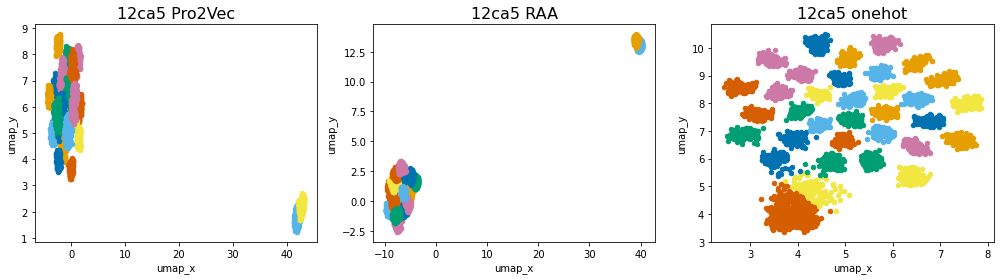

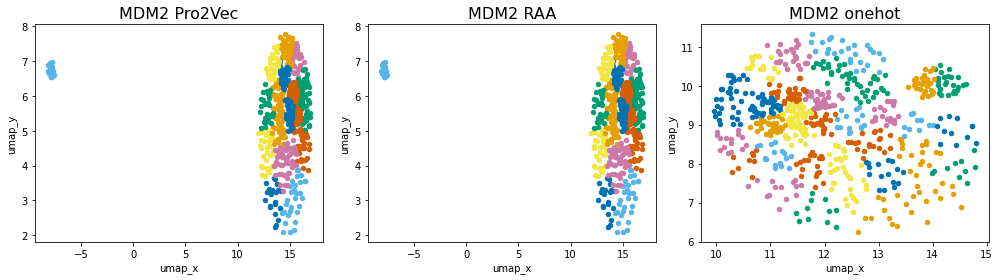

In [16]:
%%time

dfs_umap = []

for j,lib in enumerate(hit_libs):
    print(j)
    fig, axs = plt.subplots(1,3,figsize=(14,4))
    for i,rep in enumerate(reps):
        print(i)
        data_rep = lib[rep].to_list()
        if rep == 'onehot':
            data_rep = [a[0] for a in data_rep] # fixes formatting
            n_clusters = 35
        elif rep == 'onehot' and prots[j] == 'MDM2':
            n_clusters = 20
        else:
            n_clusters = 20
            
        if prots[j] == '12ca5':
            n_neighbors = 8
        else:
            n_neighbors = 5
            
        reducer_scaled = do_umap.UMAP(
            n_components=2, n_neighbors=2**n_neighbors, 
            random_state=SEED, metric='rogerstanimoto')
        embedding_scaled = reducer_scaled.fit_transform(data_rep)

        umap_fn = reducer_scaled
        umap_embedding = embedding_scaled
        
        clusterer = Pipeline(
            [
                ('kmeans',
                 KMeans(
                     n_clusters = n_clusters,
                     init = 'k-means++',
                     n_init = 50,
                     max_iter = 500,
                     random_state = SEED))])

        pipe = Pipeline(
            [
                ('clusterer',clusterer)
            ])   
            
        out = pipe.fit(umap_embedding)

        clusters = out['clusterer'].transform(umap_embedding)
        labels = out['clusterer']['kmeans'].labels_
        groups = np.unique(labels)

        df_umap = pd.DataFrame()
        df_umap['umap_x'] = umap_embedding[:,0]
        df_umap['umap_y'] = umap_embedding[:,1]
        df_umap['label'] = labels
        lib[f'opt_umap_label_{rep}_{prots[j]}'] = labels
        dfs_umap.append(df_umap)
        
        for l in np.unique(labels):
            df_sub = df_umap.query('label == @l')
            df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color = my_colorblind_colors[l], ax=axs[i])
        axs[i].set_title(f'{prots[j]} {rep}',fontsize=18)
        axs[i].set_xlabel('UMAP X',fontsize = 16)
    fig.tight_layout()
    plt.savefig(os.path.join(save_to,f'{prots[j]} Opt Clusters.png'),dpi = 300)
    fig.show()

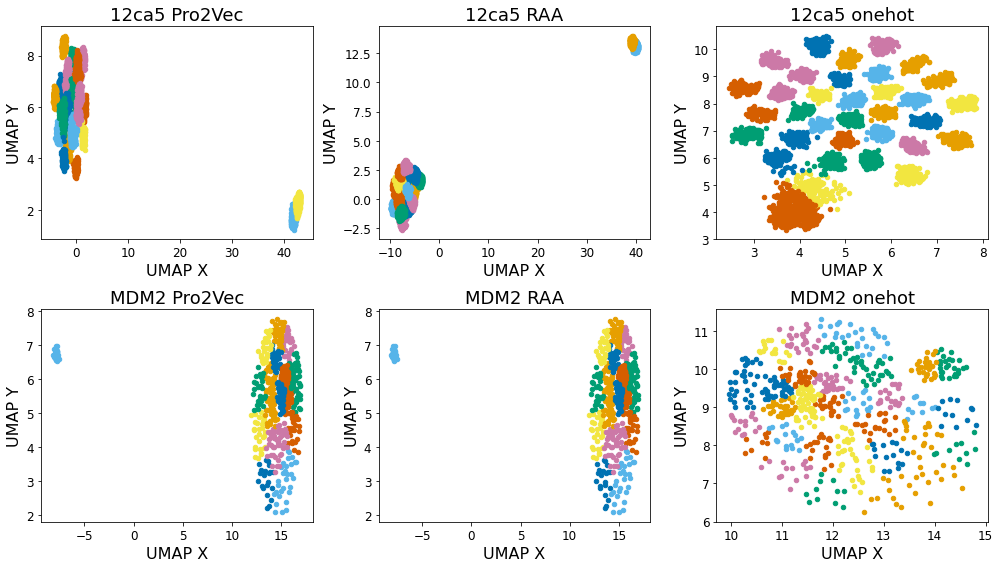

In [60]:
fig, axs = plt.subplots(2,3,figsize=(14,8))
rep_cycle = reps + reps
for i,(df_umap,axs) in enumerate(zip(dfs_umap,fig.axes)):
    j = int(np.floor(i/3))
    for l in np.unique(df_umap['label']):
        df_sub = df_umap.query('label == @l')
        df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color = my_colorblind_colors[l], ax=axs)
    axs.set_title(f'{prots[j]} {rep_cycle[i]}',fontsize=18)
    axs.set_xlabel('UMAP X',fontsize = 16)
    axs.set_ylabel('UMAP Y',fontsize = 16)
    axs.tick_params(axis='both',labelsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'12ca5, MDM2 Opt Clusters.png'),dpi = 300)
fig.show()

34


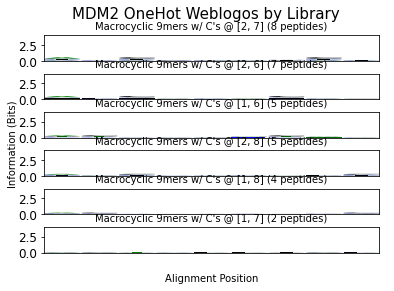

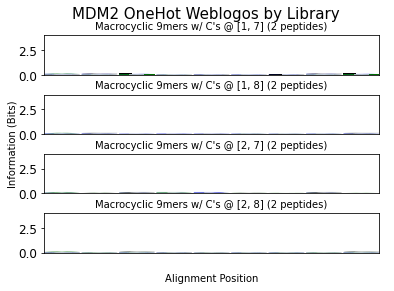

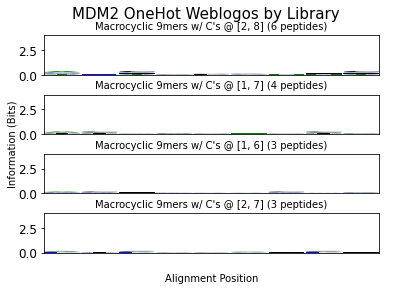

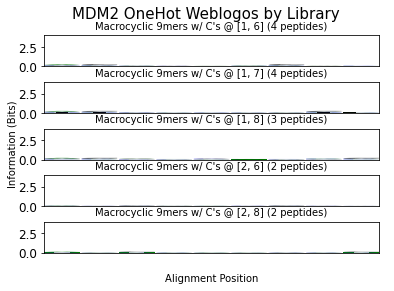

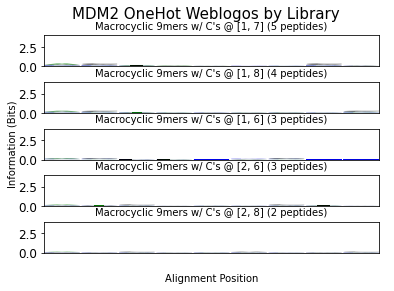

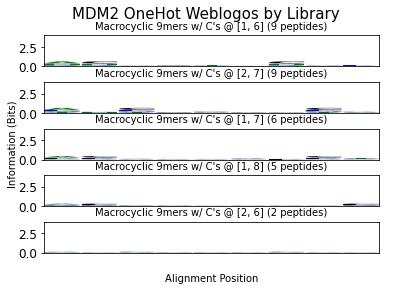

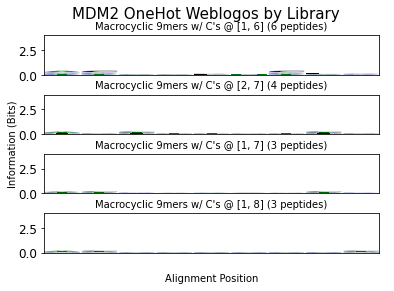

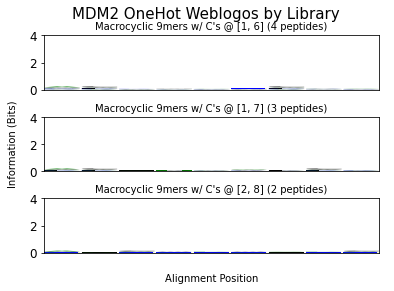

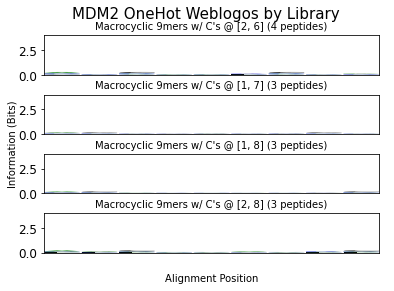

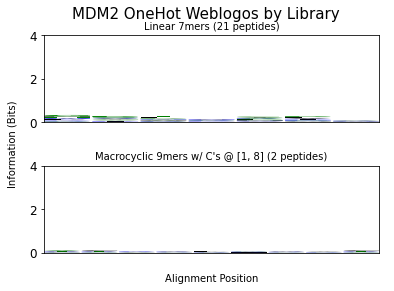

KeyboardInterrupt: 

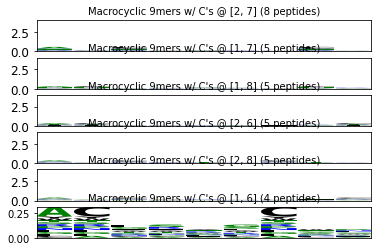

In [62]:
save_to = os.path.join('C:/','Users','Michael Lee','1 Phage Display Data','K means clustering')

key = 'opt_umap_label_onehot_MDM2'
clusters = np.unique(hit_libs[1][key])
print(max(clusters))
for cluster in clusters:
    sub_lib = hit_libs[1].query('opt_umap_label_onehot_MDM2 == @cluster')
    generate_weblogos_by_library(sub_lib,'MDM2 OneHot',f'Cluster {cluster}',save_to)

### Now using ER score

In [18]:
# ER_MDM2
R3_filt_MDM2

,Unnamed: 0,Peptide,12ca5 1,12ca5 2,12ca5 3,MDM2 1,MDM2 2,MDM2 3,12ca5 E-Score,mCDH2 E-Score,...,poi_log_fold,pvalues,log_pvalues,poi_log_pvalue,label_Pro2Vec_MDM2,label_RAA_MDM2,label_onehot_MDM2,opt_umap_label_Pro2Vec_MDM2,opt_umap_label_RAA_MDM2,opt_umap_label_onehot_MDM2
5911,29870,ACMPNHGPLC,1,0,0,18,6,24,0.011494,0.436782,...,3.198673,0.041767,-3.175651,-3.175651,2,4,0,16,16,28
6013,29973,AGCLWMLGC,0,1,0,46,11,50,0.009259,0.000000,...,3.988984,0.046332,-3.071920,-3.071920,3,0,0,2,2,17
6060,30023,ACWLTPGRC,0,0,1,29,11,18,0.016949,0.000000,...,3.384390,0.022367,-3.800167,-3.800167,3,0,0,6,6,28
6092,30057,APCLGSVCK,0,0,1,16,6,22,0.021739,0.021739,...,3.113515,0.037526,-3.282733,-3.282733,4,3,0,16,16,31
6174,30156,ACNGYSGCR,1,0,0,29,10,32,0.013889,0.000000,...,3.583519,0.027694,-3.586549,-3.586549,4,2,0,3,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62296,668042,ACLRTGCAG,0,0,0,7,5,9,0.000000,0.000000,...,3.091042,0.003738,-5.589085,-5.589085,3,3,0,9,9,10
62328,668074,ACTIRGLGC,0,0,0,9,4,8,0.000000,0.000000,...,3.091042,0.010164,-4.588938,-4.588938,3,1,0,9,9,10
62364,668110,ASCVAVPCR,0,0,0,6,5,10,0.000000,0.000000,...,3.091042,0.010164,-4.588938,-4.588938,4,4,0,11,11,10
62379,668125,AGCVVGTSC,0,0,0,10,3,8,0.000000,0.000000,...,3.091042,0.028234,-3.567218,-3.567218,3,0,0,9,9,10


In [19]:
df_ER_12ca5 = R3_filt_12ca5.merge(ER_12ca5,how='inner', on = 'Peptide')
df_ER_MDM2 = R3_filt_MDM2.merge(ER_MDM2,how='inner', on = 'Peptide')

ER_libs = [df_ER_12ca5,df_ER_MDM2]

0
0 Pro2Vec
1 RAA
2 onehot
1
0 Pro2Vec
1 RAA
2 onehot
Wall time: 17min 5s


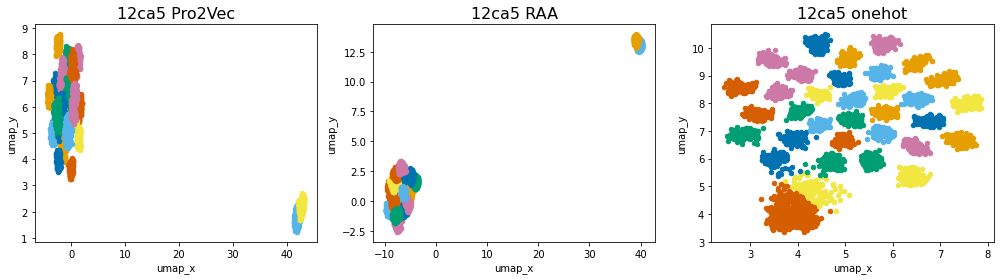

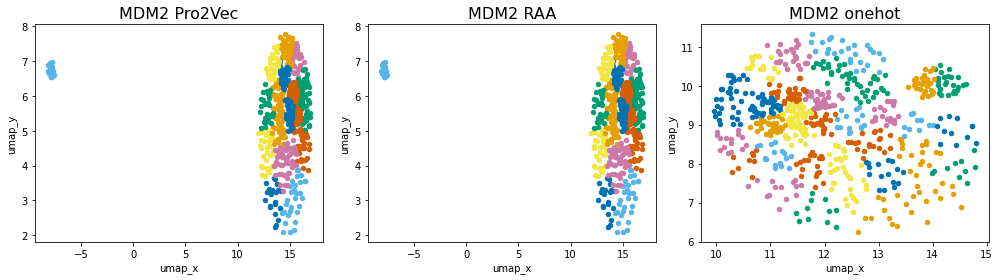

In [20]:
%%time

dfs_umap_ER = []

umap_fns_ER = {}
umap_embeddings_ER = {}

for j,lib in enumerate(ER_libs):
    print(j)
    fig, axs = plt.subplots(1,3,figsize=(14,4))
    for i,rep in enumerate(reps):
        print(i,rep)
        data_rep = lib[rep].to_list()
        if rep == 'onehot':
            data_rep = [a[0] for a in data_rep]
            n_clusters = 35
        elif rep == 'onehot' and prots[j] == 'MDM2':
            n_clusters = 20
        else:
            n_clusters = 20
            
        if prots[j] == '12ca5':
            n_neighbors = 8
        else:
            n_neighbors = 5
            
        reducer_scaled = do_umap.UMAP(
            n_components=2, n_neighbors=2**n_neighbors, 
            random_state=SEED, metric='rogerstanimoto')
        embedding_scaled = reducer_scaled.fit_transform(data_rep)

        umap_fn = reducer_scaled
        umap_embedding = embedding_scaled
        
        clusterer = Pipeline(
            [
                ('kmeans',
                 KMeans(
                     n_clusters = n_clusters,
                     init = 'k-means++',
                     n_init = 50,
                     max_iter = 500,
                     random_state = SEED))])

        pipe = Pipeline(
            [
                ('clusterer',clusterer)
            ])  
            
        out = pipe.fit(umap_embedding)

        clusters = out['clusterer'].transform(umap_embedding)
        labels = out['clusterer']['kmeans'].labels_
        groups = np.unique(labels)

        df_umap = pd.DataFrame()
        df_umap['umap_x'] = umap_embedding[:,0]
        df_umap['umap_y'] = umap_embedding[:,1]
        df_umap['label'] = labels
        lib[f'opt_umap_label_{rep}_{prots[j]}'] = labels
        dfs_umap_ER.append(df_umap)
        
        for l in np.unique(labels):
            df_sub = df_umap.query('label == @l')
            df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color = my_colorblind_colors[l], ax=axs[i])
        axs[i].set_title(f'{prots[j]} {rep}',fontsize=16)
    fig.tight_layout()
    plt.savefig(os.path.join(save_to,f'{prots[j]} Opt Clusters.png'),dpi = 300)
    fig.show()

In [63]:
save_to = os.path.join(os.getcwd(),'data','K means clustering','Color by Label')

In [64]:
for df in dfs_umap_ER:
    if len(df) > 2000:
        df['ER'] = ER_libs[0]['ER']
        df['FC'] = -ER_libs[0]['poi_log_fold']
        df['log pval'] = -ER_libs[0]['poi_log_pvalue']
    else:
        df['ER'] = ER_libs[1]['ER']
        df['FC'] = ER_libs[1]['poi_log_fold']
        df['log pval'] = -ER_libs[1]['poi_log_pvalue']

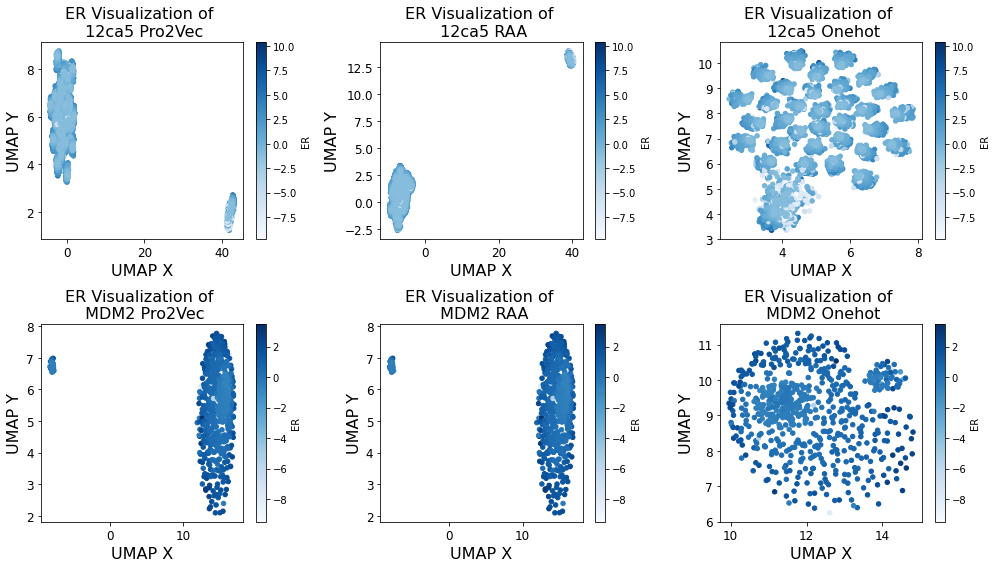

In [74]:
## color based on ER 
rep_list_names = ['12ca5 Pro2Vec','12ca5 RAA','12ca5 Onehot','MDM2 Pro2Vec','MDM2 RAA','MDM2 Onehot']

fig, axs = plt.subplots(2,3,figsize=(14,8))
for i,ax in enumerate(fig.axes):
    lib = dfs_umap_ER[i]
    plot = lib.plot.scatter(x = 'umap_x', y = 'umap_y', c = 'ER',colormap = 'Blues',ax=ax)
    ax.set_title(f'ER Visualization of \n {rep_list_names[i]}',fontsize=16)
    ax.set_xlabel('UMAP X',fontsize=16)
    ax.set_ylabel('UMAP Y',fontsize=16)
    ax.tick_params(axis='both',labelsize=12)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ind ER.png'),dpi = 300)
fig.show()

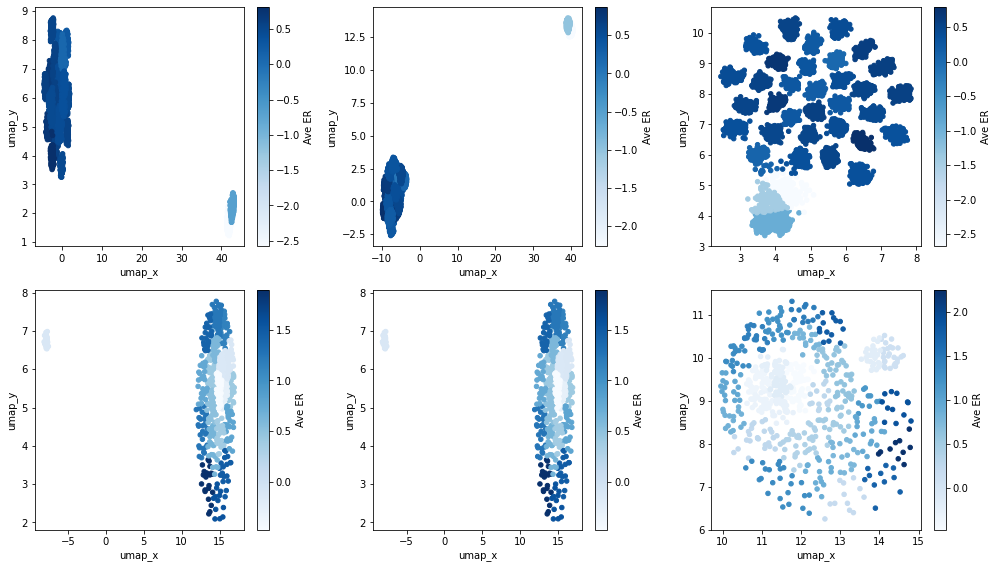

In [25]:
## color based on average in cluster

fig,axs = plt.subplots(2,3,figsize=(14,8))
for i,ax in enumerate(fig.axes):
    lib = dfs_umap_ER[i]
    labels = np.unique(lib['label'].to_list())
    df_aves = pd.DataFrame()
    for l in labels:
        df_sub = lib.query('label == @l')
        ave_ER = df_sub['ER'].mean()
        df_sub['Ave ER'] = ave_ER
        df_aves = pd.concat([df_aves,df_sub])
    df_aves.plot.scatter(x = 'umap_x', y = 'umap_y', c = 'Ave ER', colormap = 'Blues',ax=ax)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ave ER.png'),dpi = 300)
fig.show()

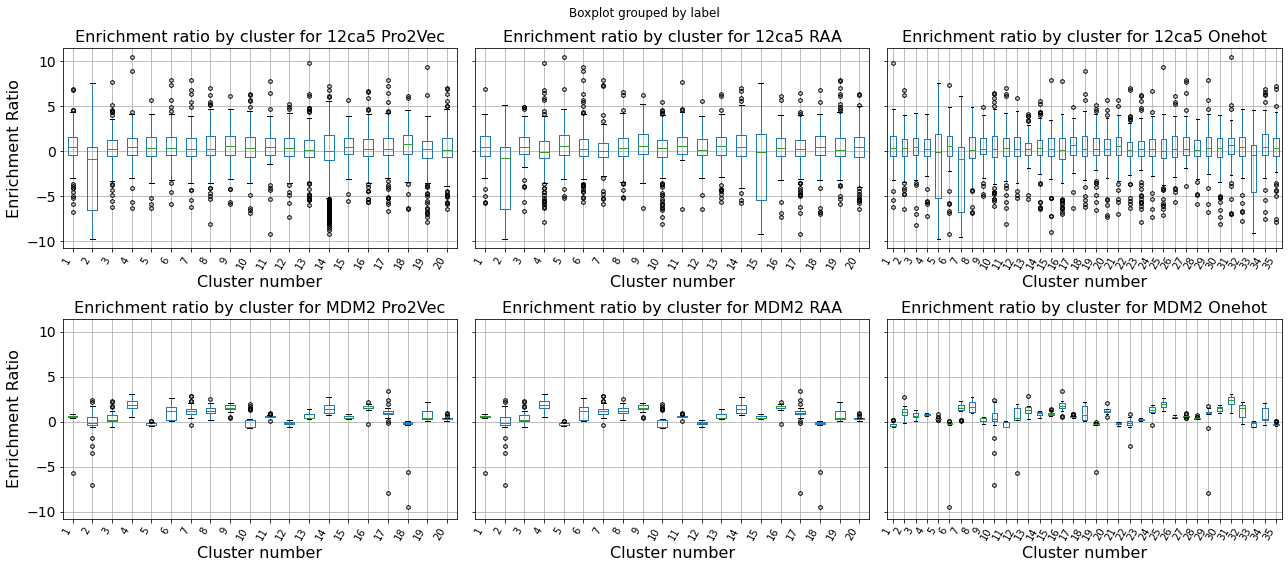

In [86]:
fig, axs = plt.subplots(2,3,figsize=(18,8),sharey=True)
for title,ax,lib in zip(rep_list_names,fig.axes,dfs_umap_ER):
    lib.boxplot(column='ER',by='label',ax=ax,
               flierprops={'marker': 'h', 'markersize': 4})
    labels  = np.unique(lib['label'].to_list())
    labels_fixed = [l+1 for l in labels]
    ax.set_xlabel('Cluster number',fontsize=16)
    ax.set_title(f'Enrichment ratio by cluster for {title}',fontsize=16)
    ax.set_xticklabels(labels_fixed,rotation=60,horizontalalignment='right')
axs[0,0].set_ylabel('Enrichment Ratio',fontsize=16)
axs[0,0].tick_params(axis='y',labelsize=14)
axs[1,0].set_ylabel('Enrichment Ratio',fontsize=16)
axs[1,0].tick_params(axis='y',labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Box and Whisker by ER.png'),dpi = 300)

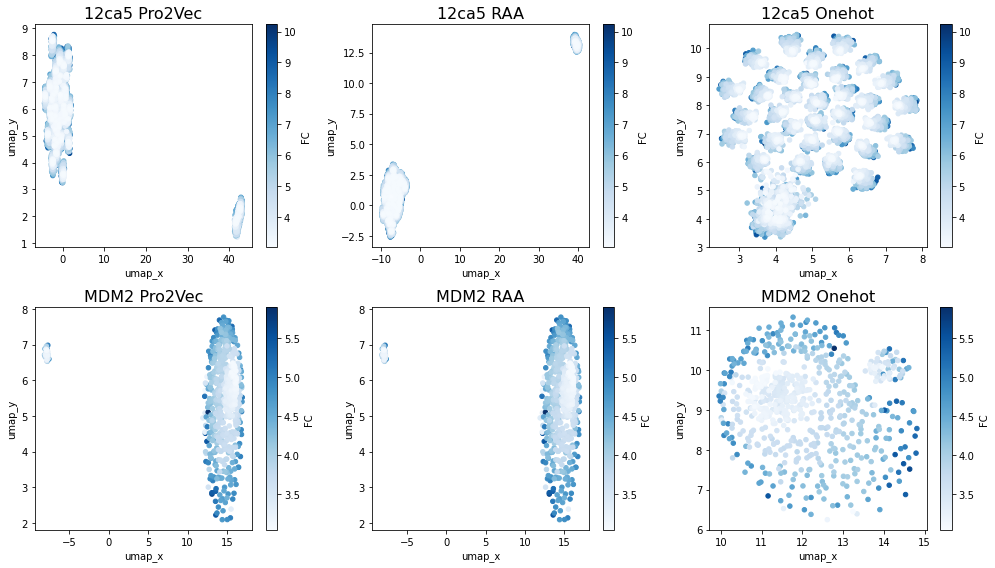

In [27]:
## color based on FC
rep_list_names = ['12ca5 Pro2Vec','12ca5 RAA','12ca5 Onehot','MDM2 Pro2Vec','MDM2 RAA','MDM2 Onehot']

fig, axs = plt.subplots(2,3,figsize=(14,8))
for i,ax in enumerate(fig.axes):
    lib = dfs_umap_ER[i]
    lib.plot.scatter(x = 'umap_x', y = 'umap_y', c = 'FC',colormap = 'Blues',ax=ax)
    ax.set_title(rep_list_names[i],fontsize=16)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ind FC.png'),dpi = 300)
fig.show()

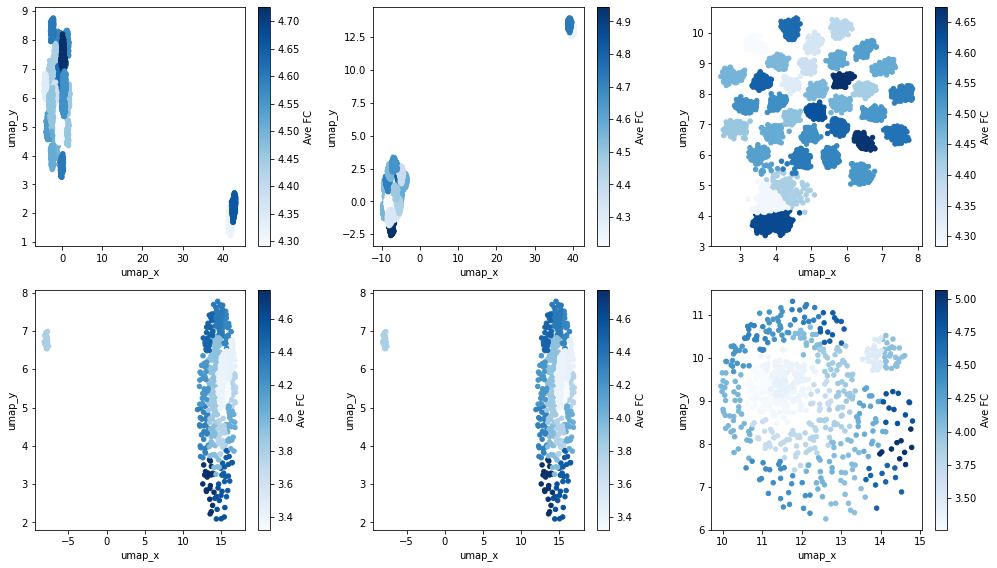

In [28]:
## color based on average in cluster

fig,axs = plt.subplots(2,3,figsize=(14,8))
for i,ax in enumerate(fig.axes):
    lib = dfs_umap_ER[i]
    labels = np.unique(lib['label'].to_list())
    df_aves = pd.DataFrame()
    for l in labels:
        df_sub = lib.query('label == @l')
        ave_FC = df_sub['FC'].mean()
        df_sub['Ave FC'] = ave_FC
        df_aves = pd.concat([df_aves,df_sub])
    df_aves.plot.scatter(x = 'umap_x', y = 'umap_y', c = 'Ave FC', colormap = 'Blues',ax=ax)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ave FC.png'),dpi = 300)
fig.show()

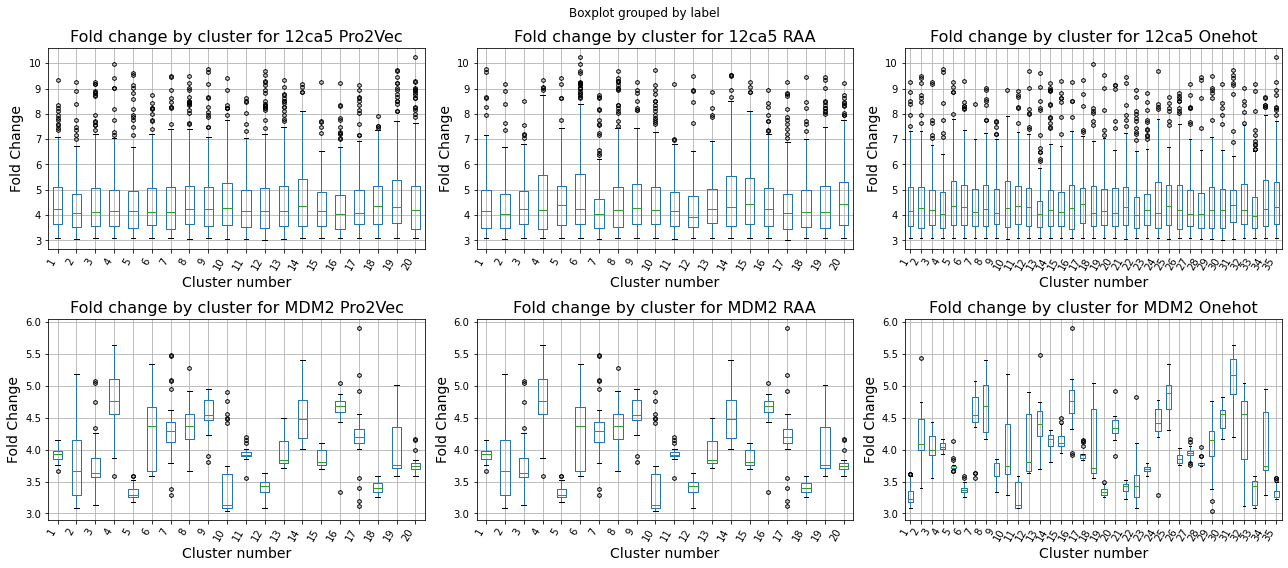

In [29]:
fig, axs = plt.subplots(2,3,figsize=(18,8))
for title,ax,lib in zip(rep_list_names,fig.axes,dfs_umap_ER):
    lib.boxplot(column='FC',by='label',ax=ax,
               flierprops={'marker': 'h', 'markersize': 4})
    labels  = np.unique(lib['label'].to_list())
    labels_fixed = [l+1 for l in labels]
    ax.set_ylabel('Fold Change',fontsize=14)
    ax.set_xlabel('Cluster number',fontsize=14)
    ax.set_title(f'Fold change by cluster for {title}',fontsize=16)
    ax.set_xticklabels(labels_fixed,rotation=60,horizontalalignment='right')
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Box and Whisker by FC.png'),dpi = 300)

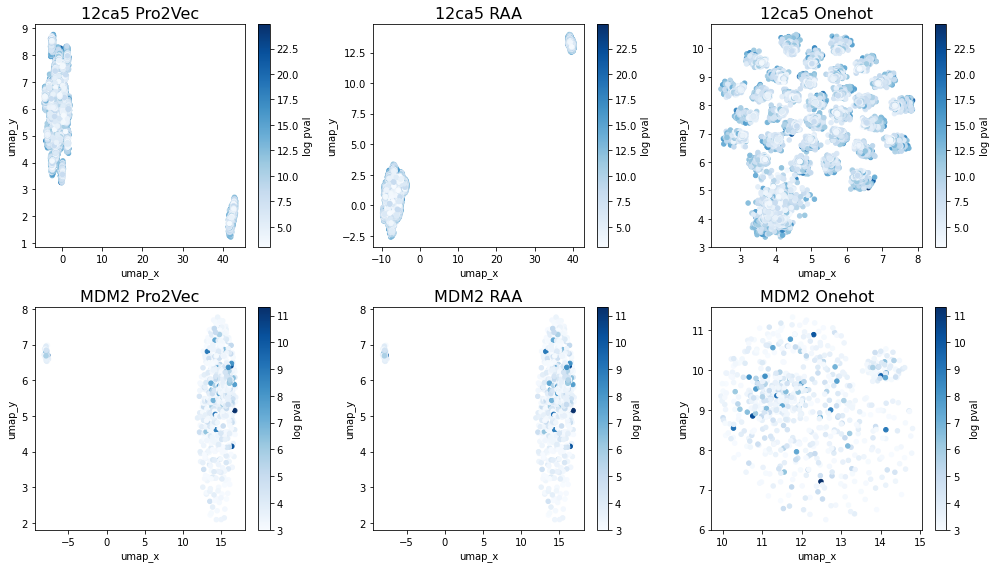

In [30]:
## color based on p value
rep_list_names = ['12ca5 Pro2Vec','12ca5 RAA','12ca5 Onehot','MDM2 Pro2Vec','MDM2 RAA','MDM2 Onehot']

fig, axs = plt.subplots(2,3,figsize=(14,8))
for i,ax in enumerate(fig.axes):
    lib = dfs_umap_ER[i]
    lib.plot.scatter(x = 'umap_x', y = 'umap_y', c = 'log pval',colormap = 'Blues',ax=ax)
    ax.set_title(rep_list_names[i],fontsize=16)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ind pval.png'),dpi = 300)
fig.show()

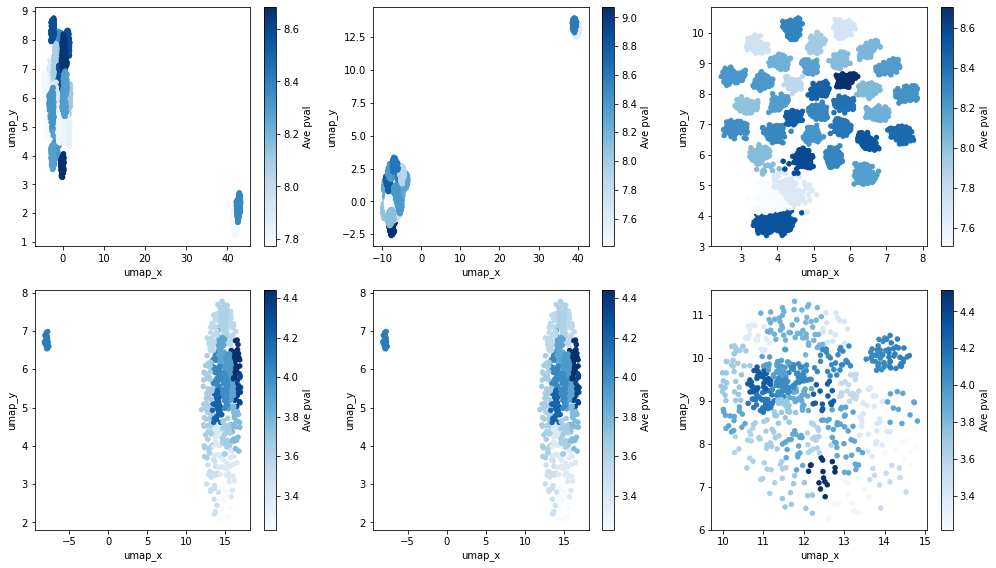

In [31]:
## color based on average in cluster
test_list = []
fig,axs = plt.subplots(2,3,figsize=(14,8))
for i,ax in enumerate(fig.axes):
    lib = dfs_umap_ER[i]
    labels = np.unique(lib['label'].to_list())
    df_aves = pd.DataFrame()
    for l in labels:
        df_sub = lib.query('label == @l')
        df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
        ave_pval = df_sub['log pval'].mean()
        test_list.append(df_sub['log pval'].to_list())
        df_sub['Ave pval'] = ave_pval
        df_aves = pd.concat([df_aves,df_sub])
    df_aves.plot.scatter(x = 'umap_x', y = 'umap_y', c = 'Ave pval', colormap = 'Blues',ax=ax)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ave pval.png'),dpi = 300)
fig.show()

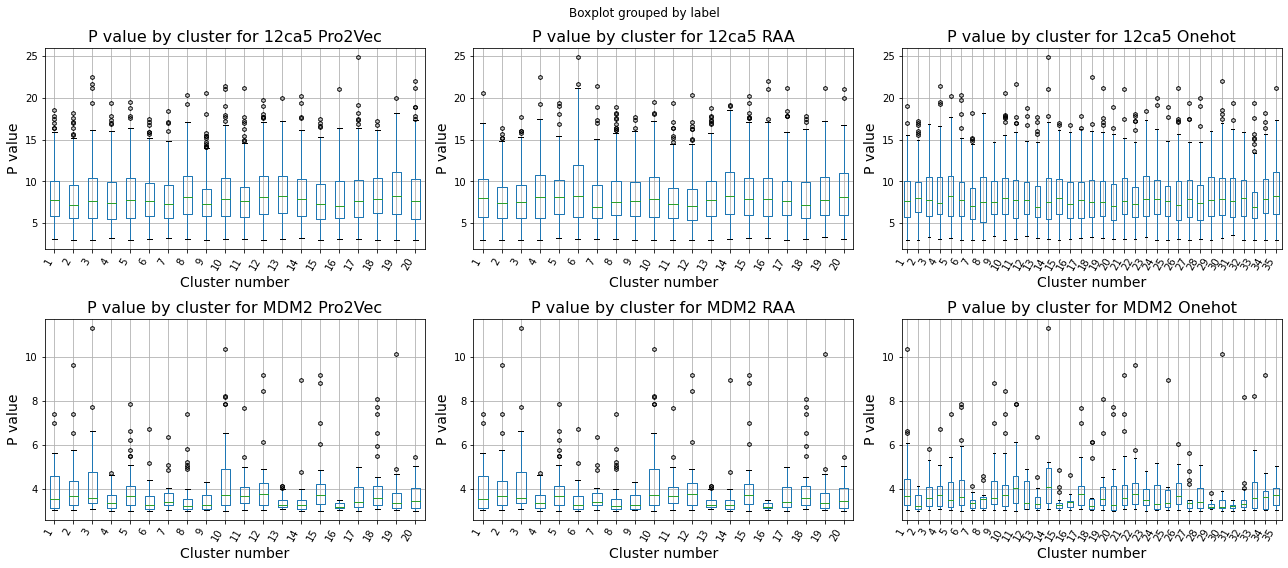

In [32]:
fig, axs = plt.subplots(2,3,figsize=(18,8))
for title,ax,lib in zip(rep_list_names,fig.axes,dfs_umap_ER):
    lib.boxplot(column='log pval',by='label',ax=ax,
               flierprops={'marker': 'h', 'markersize': 4})
    labels  = np.unique(lib['label'].to_list())
    labels_fixed = [l+1 for l in labels]
    ax.set_ylabel('P value',fontsize=14)
    ax.set_xlabel('Cluster number',fontsize=14)
    ax.set_title(f'P value by cluster for {title}',fontsize=16)
    ax.set_xticklabels(labels_fixed,rotation=60,horizontalalignment='right')
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Box and Whisker by P Val.png'),dpi = 300)